# Problem Statement

Given a question in Stack-Overflow, predict the **Technology Domain & Associated Tags** for it.

**Note** : Here we are working with a only 14 Technology Domain & less than 10% data from Stackoverflow for demonstration purpose only.

# Exploratory Data Analysis

As the rule of thumb we first check and explore our data to see how does it look like in terms of number.

We have the following raw data files :

  1. stack_network_nodes.csv** : This file lists a small subset of tags that we focus on along we their *Groups*. We have named the groups for more human understandable form for now.
  2. Questions.csv ** : This file contains the questions & related metadata for the questions from Stackoverflow
  3. Tags.csv ** : This file contains the Tags to the Questions in the previous file and are mapped via unique IDs.


  Data Source :  
  1. 
  2. 

In [1]:
# Let's mount our G-Drive. 

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Let's import our packages !
import os
import pandas as pd
import numpy as np
%matplotlib inline

## Data Loader

1. Load the CSV files with the right encoding
2. Don't forget to check the shape & head of the input files

In [0]:
path = '/content/drive/My Drive/ICDMAI_Tutorial'

In [5]:
# Load the Tags & Group relationship
tag_grp_path = path + '/stack-overflow-tag-network/stack_network_nodes.csv'
tag_grp_id = pd.read_csv(tag_grp_path)

print("tag-Group Mapping CSV Shape :{} ".format(tag_grp_id.shape))
tag_grp_id.head()

tag-Group Mapping CSV Shape :(115, 8) 


,name,group,nodesize,group_name,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,html,6,272.45,Front-end/Designing,NaN,NaN,NaN,NaN
1,css,6,341.17,Front-end/Designing,NaN,NaN,NaN,NaN
2,hibernate,8,29.83,MVC,NaN,NaN,NaN,NaN
3,spring,8,52.84,MVC,NaN,NaN,NaN,NaN
4,ruby,3,70.14,Server Side Development,NaN,NaN,NaN,NaN


In [0]:
# Load Stackoverflow Questions
questions_path  = path + '/stacksample/Questions.csv'
question = pd.read_csv(questions_path,encoding='latin-1',engine='python')

print("Questions CSV Shape :{} ".format(question.shape))
question.head()

Questions CSV Shape :(1264216, 7) 


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [0]:
# Checking the data types 
question.dtypes

Id                int64
OwnerUserId     float64
CreationDate     object
ClosedDate       object
Score             int64
Title            object
Body             object
dtype: object

In [0]:
# Load the Tags for the Question IDs in the question
question_tag_path = path  + '/stacksample/Tags.csv'

question_tag = pd.read_csv(question_tag_path,encoding='latin-1')
print("Tags CSV Shape :{} ".format(question_tag.shape))
question_tag.head()

Tags CSV Shape :(3750994, 2) 


,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


# Data Exploration

We will perform a number of quick explorations and massage the data for our use-case.For the Demonstration, we are using a fairly smaller dataset of Stackoverflow. But yet it's not that small (~1M questions)

### 1. Checking Creation date & it's distribution

Though we don't use it, but it shows that December has the least number of questions. Holiday Season much

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,CreationMonth,CreationYear
0,80,26.0,2008-08-01 13:57:07,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,8,2008
1,90,58.0,2008-08-01 14:41:24,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,8,2008
2,120,83.0,2008-08-01 15:50:08,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,8,2008
3,180,2089740.0,2008-08-01 18:42:19,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,8,2008
4,260,91.0,2008-08-01 23:22:08,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,8,2008


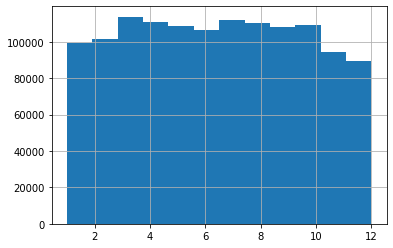

In [0]:
# Changing Object to DateTime format. Also segregating Month & Year

question['CreationDate'] = question['CreationDate'].astype('datetime64[ns]') 
question['CreationMonth'] = question['CreationDate'].apply(lambda x : x.month)
question['CreationYear'] = question['CreationDate'].apply(lambda x : x.year)

# Checking Distribution of Creation month for Questions
question['CreationMonth'].hist(bins=12)

question.head()

### 2. Checking  occurence of unique of Tags

In 10% sample from Stackoverflow that we have it's shocking to see that we have ~37K Tags.

### Things to Wonder ?
* Are there spelling mistake in Tags ?
* Can javascript or java be tagged as something else too by mistake ?

In [0]:
# Grouping Tags to check frequency of Occurence in the Tags 

tag_group = question_tag.groupby(by='Tag', as_index=False).agg({'Id': "count"})
tag_group = tag_group.rename(columns = {'Id': "occurence_count"})
tag_group = tag_group.sort_values(by=['occurence_count'],ascending=False)
print("Shape : {}".format(tag_group.shape))

tag_group.head()

Shape : (37034, 2)


,Tag,occurence_count
16121,javascript,124155
16020,java,115212
4301,c#,101186
24211,php,98808
979,android,90659


We filter out the tags to only keep Tags for which we have defined Technology Domain. This leaves us with 112 Tags for our dataset only.

In [0]:
# Merging to get Groups

question_tag_grp =  pd.merge(tag_group,tag_grp_id, left_on='Tag',right_on='name')
question_tag_grp.pop('name')
print("Shape : {}".format(question_tag_grp.shape))

question_tag_grp.head()

Shape : (112, 4)


,Tag,occurence_count,group,nodesize
0,javascript,124155,6,649.16
1,java,115212,8,610.65
2,c#,101186,2,321.13
3,php,98808,6,361.22
4,android,90659,4,229.86


### 3. Check Occurence Ratio
We evaluate the presence of a single Tag in the entire Dataset when compared with all the tags.

It seems even the most occuring Tag like **javascript** or **java** has just a mere 7% occurence

In [0]:
# Total Tags Occerence 
occurence_sum = question_tag_grp['occurence_count'].sum()
print("Total Occurence Sum : {} ".format(occurence_sum))

# Evaluating % presence
question_tag_grp['occurence_ratio'] =  question_tag_grp['occurence_count'].apply(lambda x : x/occurence_sum)
question_tag_grp.head()

Total Occurence Sum : 1621335 


,Tag,occurence_count,group,nodesize,occurence_ratio
0,javascript,124155,6,649.16,0.076576
1,java,115212,8,610.65,0.071060
2,c#,101186,2,321.13,0.062409
3,php,98808,6,361.22,0.060942
4,android,90659,4,229.86,0.055916


### 4. Filtering Questions & Tags

Based on the Tags we have for the defined groups, we filter the Questions & related tags from the dataset.

In [0]:
# Filtering Tags

print("Initial # of Question-Tag mapping with 37k tags : {}".format(question_tag.shape))

filtered_question_tag =  pd.merge(question_tag,question_tag_grp,left_on='Tag',right_on='Tag')
print("Filtered # of Question-Tag mapping with 112 Tags : {}".format(filtered_question_tag.shape))

decrease =  question_tag.shape[0] -filtered_question_tag.shape[0]
print("Reduction : {}".format(decrease))
print("Reduction of {0: .3f} % in the dataset density due to removal of Tags".format((decrease/question_tag.shape[0]) * 100 ))

filtered_question_tag.head()

Initial # of Question-Tag mapping with 37k tags : (3750994, 2)
Filtered # of Question-Tag mapping with 112 Tags : (1621335, 6)
Reduction : 2129659
Reduction of  56.776 % in the dataset due to removal of Tags


,Id,Tag,occurence_count,group,nodesize,occurence_ratio
0,120,sql,35782,2,154.23,0.022069
1,1970,sql,35782,2,154.23,0.022069
2,2120,sql,35782,2,154.23,0.022069
3,2840,sql,35782,2,154.23,0.022069
4,4110,sql,35782,2,154.23,0.022069


In [0]:
# Grouping Tags on Document Level
# As 1 Document has multiple tags

question_tag_mapping = filtered_question_tag.groupby(by='Id', as_index=False).agg({'Tag':lambda x: list(set(x))})

print("Filtered # of Tag occurence for Training : {}".format(filtered_question_tag.shape[0]))
print("Grouped  # of Tag occurence for Training: {}".format(question_tag_mapping.shape[0]))

question_tag_mapping.head()

Filtered # of Tag occurence for Training : 1621335
Grouped  # of Tag occurence for Training: 1051992


,Id,Tag
0,120,"[sql, asp.net]"
1,260,"[.net, c#]"
2,330,[c++]
3,470,"[.net, web-services]"
4,580,[sql-server]


In [0]:
### Filtering Questions based on the Groups of Tags & Merging them

filtered_questions =  pd.merge(question,question_tag_mapping)

print("Original # of Questions for Training : {}".format(question.shape[0]))
print("Unique Questions for Training after filtering : {}".format(filtered_questions.shape[0]))
print("Reduction in Dataset  : {}".format(question.shape[0]-filtered_questions.shape[0]))
 
reduction_percentage = ((question.shape[0] - filtered_questions.shape[0])/question.shape[0]) * 100
print("Reduction of {0:.3f} % in Questions Dataset".format(reduction_percentage))

filtered_questions.head()

Original # of Questions for Training : 1264216
Unique Questions for Training after filtering : 1051992
Reduction in Dataset  : 212224
Reduction of 16.787 % in Questions Dataset


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Tag
0,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
1,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[.net, c#]"
2,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,[c++]
3,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,"[.net, web-services]"
4,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,[sql-server]


#### 5.  Checking Distribution in Data

,Id,Tag,tag_count
0,120,"[sql, asp.net]",2
1,260,"[.net, c#]",2
2,330,[c++],1
3,470,"[.net, web-services]",2
4,580,[sql-server],1


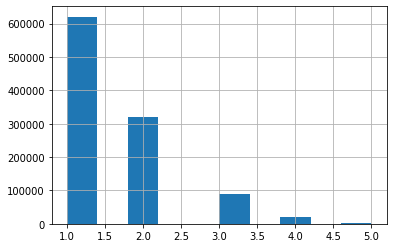

In [0]:
## Checking Tags Count Distribution on Document Level

question_tag_mapping['tag_count'] = question_tag_mapping['Tag'].apply(lambda x : len(x))
question_tag_mapping['tag_count'].hist()
question_tag_mapping.head()

In [0]:
filtered_question_tag.head()

,Id,Tag,occurence_count,group,nodesize,occurence_ratio
0,120,sql,35782,2,154.23,0.022069
1,1970,sql,35782,2,154.23,0.022069
2,2120,sql,35782,2,154.23,0.022069
3,2840,sql,35782,2,154.23,0.022069
4,4110,sql,35782,2,154.23,0.022069


,Tag,occurence_count,group,nodesize,occurence_ratio
0,javascript,124155,6,649.16,0.076576
1,java,115212,8,610.65,0.071060
2,c#,101186,2,321.13,0.062409
3,php,98808,6,361.22,0.060942
4,android,90659,4,229.86,0.055916


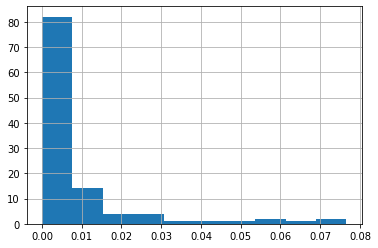

In [0]:
question_tag_grp['occurence_ratio'] = question_tag_grp['occurence_ratio'] * 100
question_tag_grp['occurence_ratio'].hist(bins=10)
question_tag_grp.head()

In [0]:
# Grouping Tags-Group for a Single Document

question_group_mapping = filtered_question_tag.groupby(by='Id', as_index=False).agg({'group':lambda x: list(x)})

print("Unique Questions for Training : {}".format(question_group_mapping.shape))
question_group_mapping.head()

Unique Questions for Training : (1051992, 2)


,Id,group
0,120,"[2, 2]"
1,260,"[2, 2]"
2,330,[1]
3,470,"[2, 8]"
4,580,[2]


,Id,group,unique_grp_count,grp_count
0,120,"[2, 2]",1,2
1,260,"[2, 2]",1,2
2,330,[1],1,1
3,470,"[2, 8]",2,2
4,580,[2],1,1


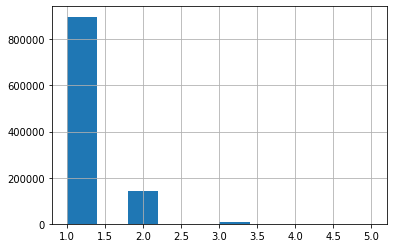

In [0]:
## Checking Group Count Distribution on Document Level for Uniqueness

question_group_mapping['unique_grp_count'] = question_group_mapping['group'].apply(lambda x : len(set(x)))
question_group_mapping['grp_count'] = question_group_mapping['group'].apply(lambda x : len(x))
question_group_mapping['unique_grp_count'].hist()
question_group_mapping.head()

In [0]:
# Check % of Documents with Multiple Tags in the Training Data 

mulitple_tags_count = question_group_mapping[question_group_mapping.grp_count != question_group_mapping.unique_grp_count].shape[0]

print("# of Documents with Multiple Tags : {}".format(mulitple_tags_count))
print("{0:.3f} % of Document has Multiple Tags in training data ".format((mulitple_tags_count/question_group_mapping.shape[0])*100))

# of Documents with Multiple Tags : 318884
30.312 % of Document has Multiple Tags in training data 


In [0]:
# Overall view of tag vs documents count
filtered_questions_copy = filtered_questions

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
filtered_questions_copy['group_Tag'] = filtered_questions_copy['Tag']
filtered_questions_copy = filtered_questions_copy.join(pd.DataFrame(mlb.fit_transform(filtered_questions_copy.pop('group_Tag')),
                          columns=mlb.classes_,
                          index=filtered_questions_copy.index))

question_tag_summary = filtered_questions_copy.drop(['Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title',
       'Body', 'CreationMonth', 'CreationYear','Tag'], axis=1)
categories = list(question_tag_summary.columns.values)
for i in categories:
    counts.append((i, question_tag_summary[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_questions'])

df_stats.plot(x='category', y='number_of_questions', kind='bar', legend=False, grid=True, figsize=(40, 5))
plt.title("Number of documents per tag")
plt.ylabel('# of documents', fontsize=12)
plt.xlabel('tag', fontsize=12)

In [0]:
# Histogram of docuement len
lens = filtered_questions_copy.Body.str.len()
lens.hist(bins = np.arange(0,5000,50))

### 6. Saving Filtered Data

In [0]:
filtered_question_tag.head()
filtered_question_tag.to_pickle('./filtered_data/question_tag_group_mapping.pkl')

,Id,Tag,occurence_count,group,nodesize,occurence_ratio
0,120,sql,35782,2,154.23,0.022069
1,1970,sql,35782,2,154.23,0.022069
2,2120,sql,35782,2,154.23,0.022069
3,2840,sql,35782,2,154.23,0.022069
4,4110,sql,35782,2,154.23,0.022069


In [0]:
filtered_questions.head()
filtered_questions.to_pickle('./filtered_data/question_tag_text_mapping.pkl')

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,CreationMonth,CreationYear,Tag
0,120,83.0,2008-08-01 15:50:08,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,8,2008,"[asp.net, sql]"
1,260,91.0,2008-08-01 23:22:08,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,8,2008,"[.net, c#]"
2,330,63.0,2008-08-02 02:51:36,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,8,2008,[c++]
3,470,71.0,2008-08-02 15:11:47,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,8,2008,"[web-services, .net]"
4,580,91.0,2008-08-02 23:30:59,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,8,2008,[sql-server]


In [0]:
question_tag_mapping.head()
question_tag_mapping.to_pickle('./filtered_data/question_tag_id_mapping.pkl')

,Id,Tag,tag_count
0,120,"[sql, asp.net]",2
1,260,"[.net, c#]",2
2,330,[c++],1
3,470,"[.net, web-services]",2
4,580,[sql-server],1


In [0]:
question_group_mapping.head()
question_group_mapping.to_pickle('./filtered_data/question_group_mapping.pkl'

,Id,group,unique_grp_count,grp_count
0,120,"[2, 2]",1,2
1,260,"[2, 2]",1,2
2,330,[1],1,1
3,470,"[2, 8]",2,2
4,580,[2],1,1
